## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy
from scipy.optimize import minimize

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(42)

In [3]:
def ansatz_custom(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [4]:
#def ansatz_inverse(params, n_wires_latent, n_wires_trash):
#    params = params[::-1]
#    for j in reversed(range(5)):
#        if j != 4:
#            for i in reversed(range(n_wires_latent + n_wires_trash - 1)):
#                qml.CNOT(wires=[i, i+1])
#        for i in reversed(range(n_wires_latent + n_wires_trash)):
#            k = j*5+i
#            qml.RY(-params[k], wires=i)


In [5]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [6]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [7]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [8]:
def quantum_encoder_train(params, n_wires_latent, n_wires_trash):
    ansatz_custom(params,n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)

In [9]:
@qml.qnode(dev)
def domain_wall(params):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(params, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [10]:
params = np.random.random((30,))
params = qml.numpy.tensor(params, requires_grad=True)

(<Figure size 2400x900 with 1 Axes>, <Axes: >)


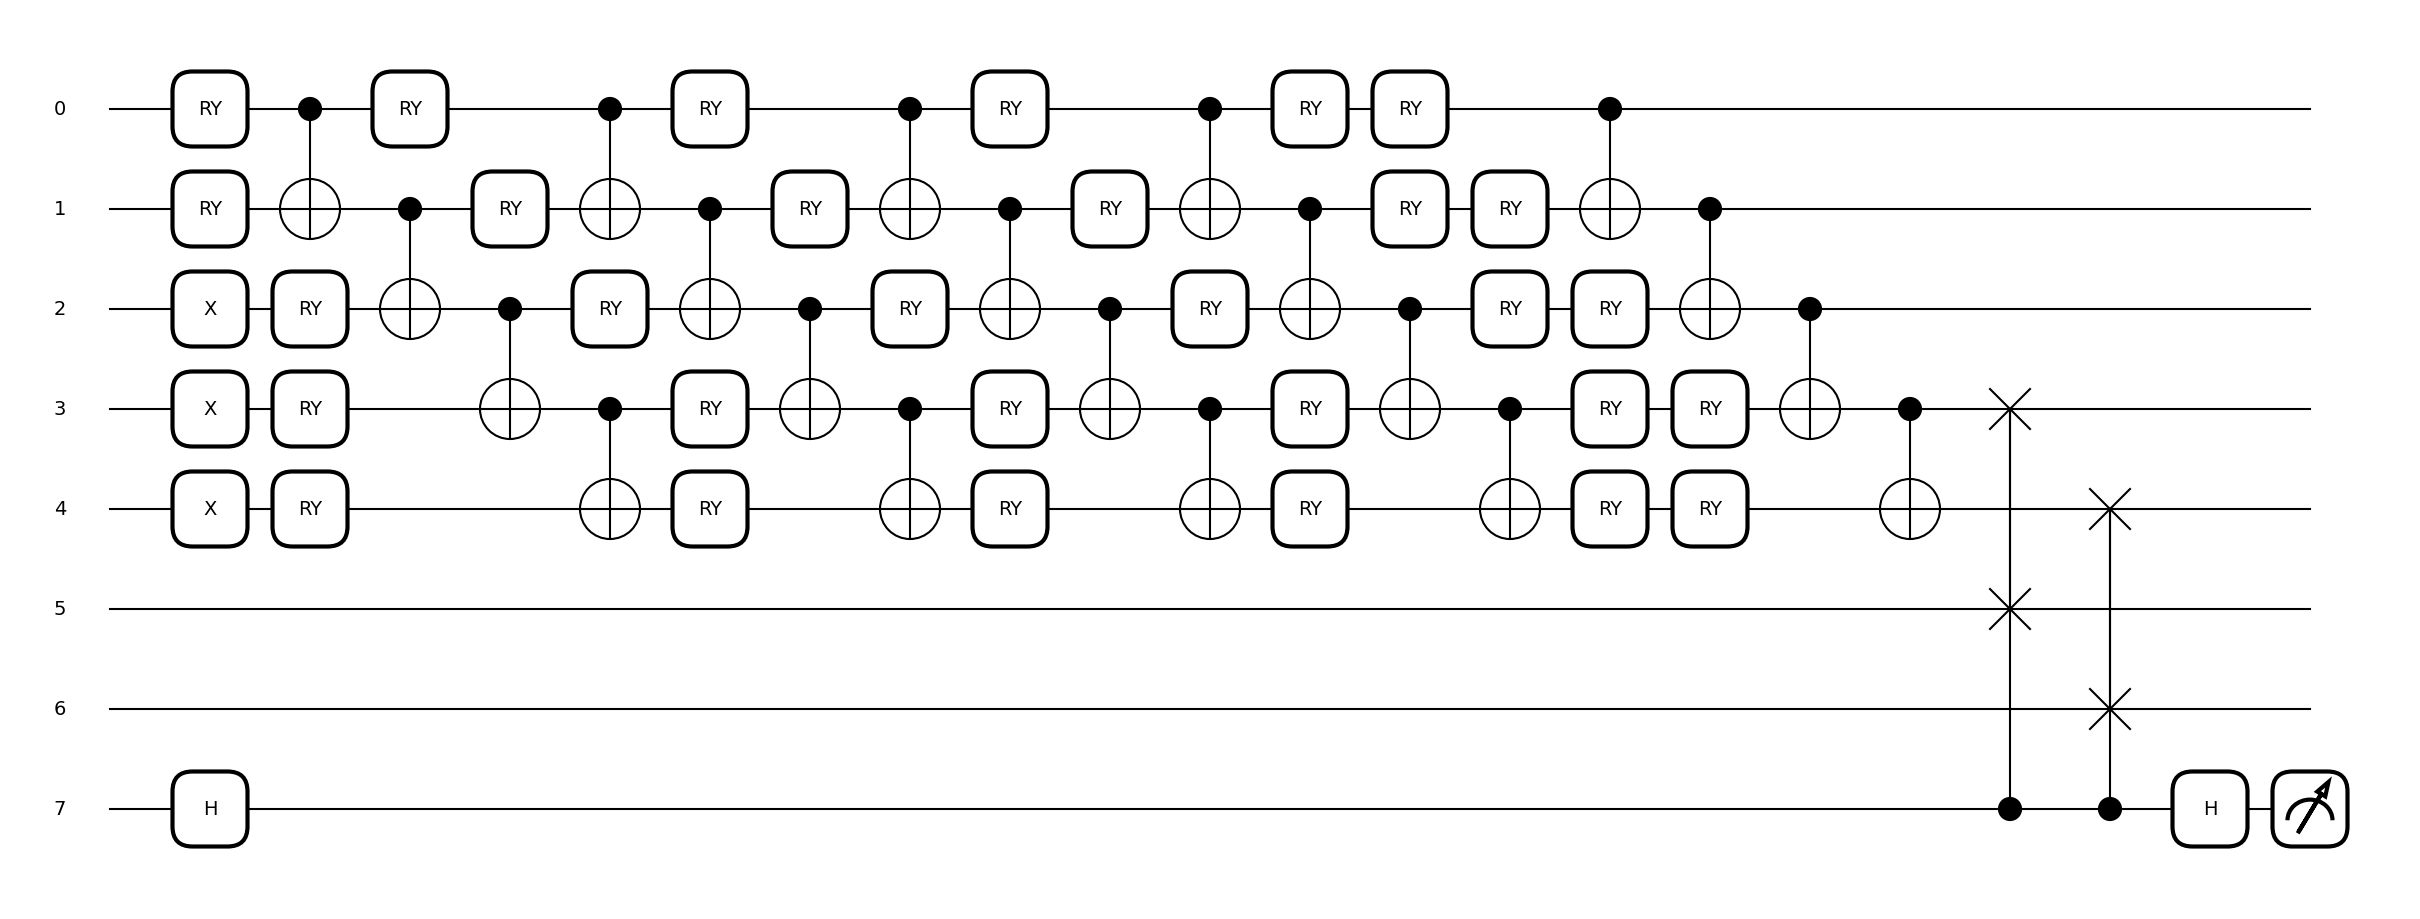

In [11]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [12]:
def cost_function(params):
    probs = domain_wall(params)
    cost = np.sum(probs[1])
    return cost

In [13]:
cost_values = []
opt_weights = []
def callback(xk):
    cost_val = cost_function(xk)
    cost_values.append(cost_val)
    opt_weights.append(xk)
    print(f"Step {len(cost_values)}: cost = {cost_val:.4f}, params = {xk}")

In [14]:
minimize(cost_function, params, method='COBYLA', callback=callback, options={'maxiter': 250})
opt_weights = opt_weights[-1]

Step 1: cost = 0.3396, params = [1.18343479e+00 7.79691000e-01 5.96850158e-01 4.45832753e-01
 9.99749158e-02 4.59248892e-01 3.33708611e-01 1.42866818e-01
 6.50888473e-01 5.64115790e-02 7.21998772e-01 9.38552709e-01
 7.78765841e-04 9.92211559e-01 6.17481510e-01 6.11653160e-01
 7.06630522e-03 2.30624250e-02 5.24774660e-01 3.99860972e-01
 4.66656632e-02 9.73755519e-01 2.32771340e-01 9.06064345e-02
 6.18386009e-01 3.82461991e-01 9.83230886e-01 4.66762893e-01
 8.59940407e-01 6.80307539e-01]
Step 2: cost = 0.3546, params = [1.18343479e+00 1.77969100e+00 5.96850158e-01 4.45832753e-01
 9.99749158e-02 4.59248892e-01 3.33708611e-01 1.42866818e-01
 6.50888473e-01 5.64115790e-02 7.21998772e-01 9.38552709e-01
 7.78765841e-04 9.92211559e-01 6.17481510e-01 6.11653160e-01
 7.06630522e-03 2.30624250e-02 5.24774660e-01 3.99860972e-01
 4.66656632e-02 9.73755519e-01 2.32771340e-01 9.06064345e-02
 6.18386009e-01 3.82461991e-01 9.83230886e-01 4.66762893e-01
 8.59940407e-01 6.80307539e-01]
Step 3: cost = 0.3

In [15]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights])


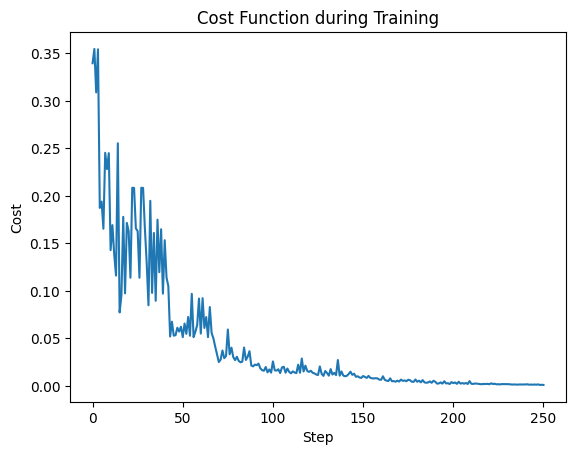

In [16]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [17]:
print(cost_values[-1])

0.0009328496930756407


In [18]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [19]:
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [20]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz_custom(opt_weights, n_wires_latent, n_wires_trash) 
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(ansatz_custom)(opt_weights, n_wires_latent, n_wires_trash)
    #return [qml.expval(qml.PauliZ(i)) for i in range(5)] # To get the expectation values but we need the density matrix to use qml.math.fidelity
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 4300x700 with 1 Axes>, <Axes: >)


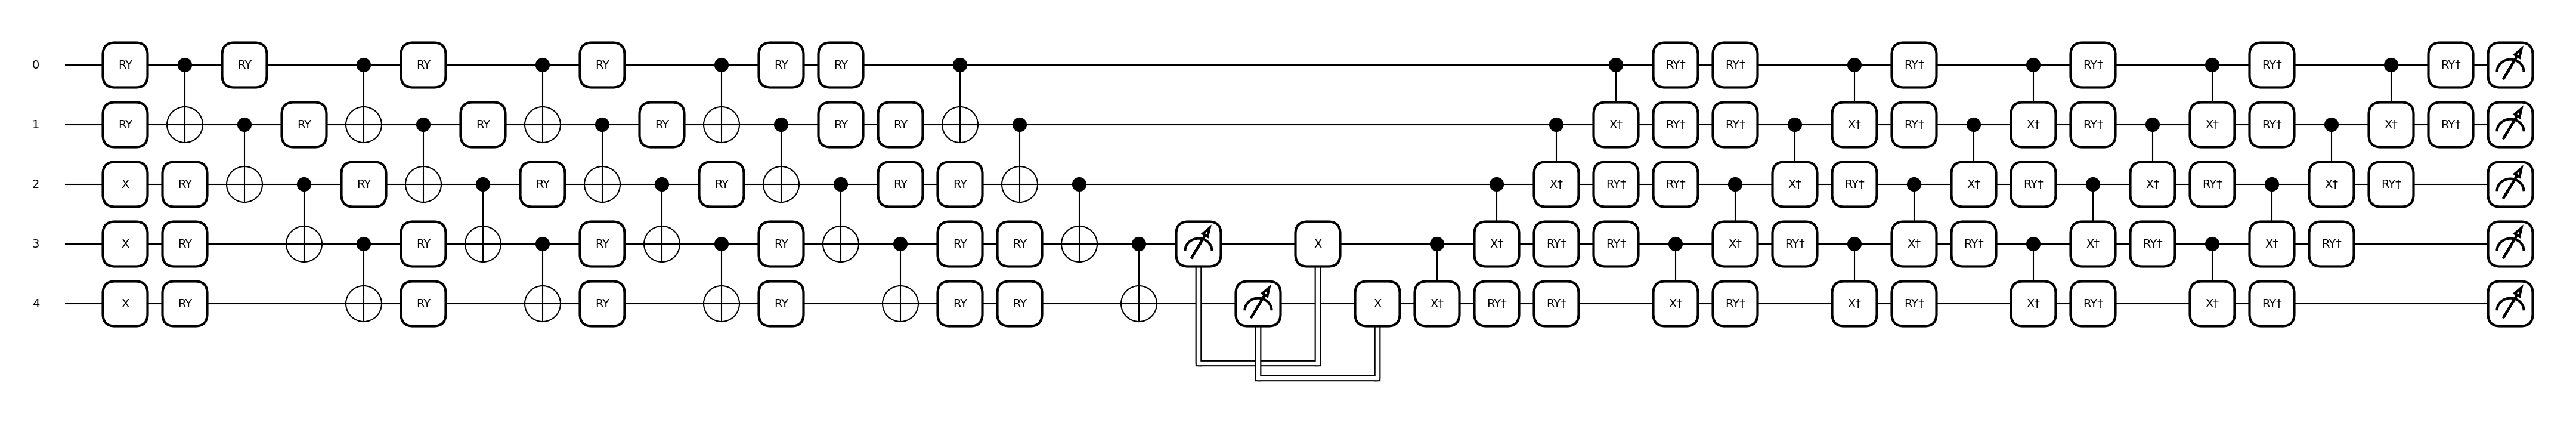

In [21]:
drawer_1 = qml.draw_mpl(autoencoder)
print(drawer_1(opt_weights))

In [22]:
dev_initial = qml.device("default.qubit", wires=5)
@qml.qnode(dev_initial)
def initial_state_dom():
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    return qml.density_matrix([0,1,2,3,4])

(<Figure size 400x600 with 1 Axes>, <Axes: >)


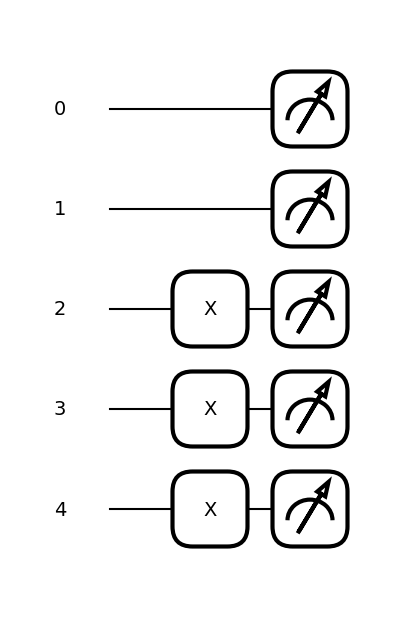

In [23]:
drawer_6 = qml.draw_mpl(initial_state_dom)
print(drawer_6())

In [24]:
print(qml.math.fidelity(initial_state_dom(), autoencoder(opt_weights)))

0.996279767526788


# To not use "reset_to_zero" #

In [25]:
dev_autoencoder5 = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash+2)
@qml.qnode(dev_autoencoder5)
def autoencoder_swap(opt_weights):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz_custom(opt_weights, n_wires_latent, n_wires_trash) 
    qml.SWAP(wires=[3, 6])
    qml.SWAP(wires=[4, 5])
    qml.adjoint(ansatz_custom)(opt_weights, n_wires_latent, n_wires_trash)
    return qml.density_matrix([0,1,2,3,4])

(<Figure size 4100x800 with 1 Axes>, <Axes: >)


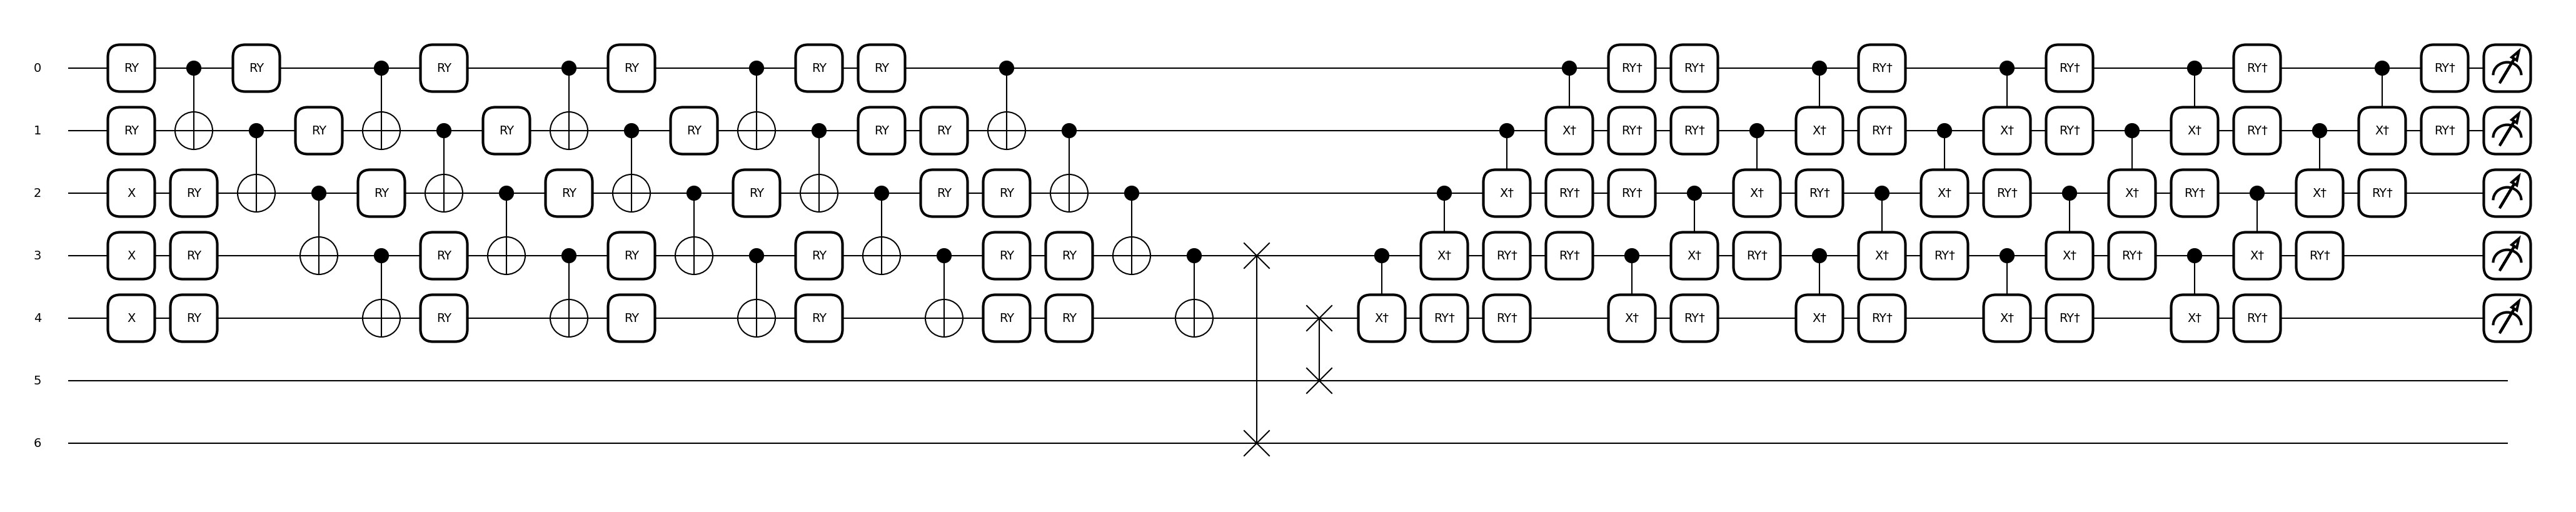

In [26]:
drawer_6 = qml.draw_mpl(autoencoder_swap)
print(drawer_6(opt_weights))

In [27]:
print(qml.math.fidelity(initial_state_dom(), autoencoder_swap(opt_weights)))

0.996279767526788


# DIGIT DATASET #

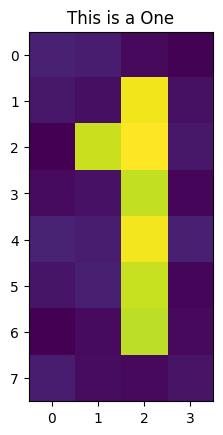

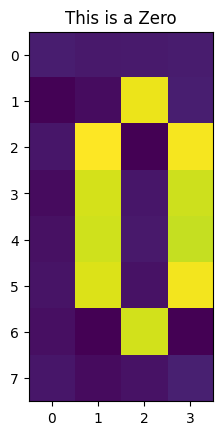

In [28]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)


        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = np.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = np.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, train_labes = get_dataset_digits(2)

In [29]:
image_0= train_images[0]
image_1 = train_images[1]
print(image_0)

[0.03843112 0.03217335 0.0121233  0.00388725 0.02723174 0.0175176
 0.38892485 0.01970751 0.00136863 0.36609901 0.39746738 0.02636768
 0.01240577 0.02069815 0.36115737 0.00735701 0.03858843 0.03084945
 0.39011692 0.03561317 0.02379578 0.0366896  0.36379897 0.00779991
 0.0018     0.0129478  0.35841011 0.0107994  0.03298286 0.0141984
 0.01118089 0.02159872]


In [30]:
def ansatz_custom_digits(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [31]:
@qml.qnode(dev)
def train_circuit(params, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [32]:
params_digits = np.random.random((30,))
params_digits = qml.numpy.tensor(params_digits, requires_grad=True)

(<Figure size 4000x900 with 1 Axes>, <Axes: >)


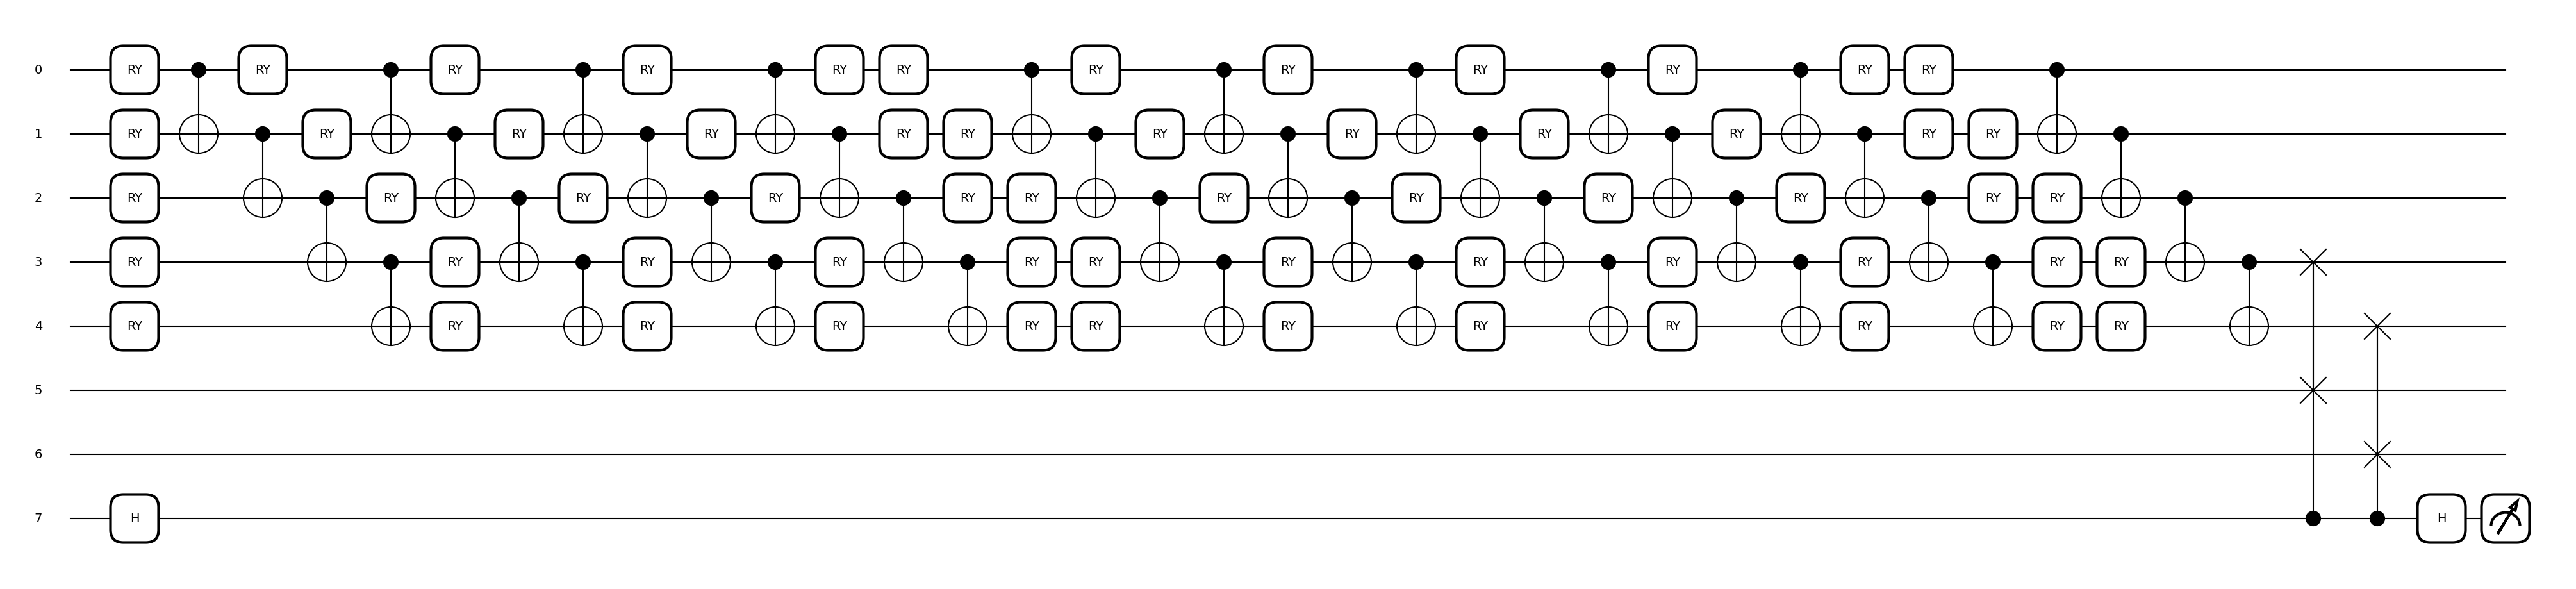

In [33]:
drawer_2 = qml.draw_mpl(train_circuit)
print(drawer_2(params_digits, image_0))

In [34]:
def cost_function_digits(weights):
    probabilities = [train_circuit(weights, image) for image in train_images]
    print(probabilities)
    cost_value = np.sum([p[1] for p in probabilities])/train_images.shape[0]
    return cost_value

In [35]:
cost_values_digits = []
opt_weights_digits = []
def callback(xk):
    cost_val = cost_function_digits(xk)
    cost_values_digits.append(cost_val)
    opt_weights_digits.append(xk)
    print(f"Step {len(cost_values_digits)}: cost = {cost_val:.4f}, params = {xk}")

In [36]:
minimize(cost_function_digits, params_digits, method='COBYLA', callback=callback, options={'maxiter': 500})
opt_weights_digits = opt_weights_digits[-1]

[tensor([0.56418311, 0.43581689], requires_grad=True), tensor([0.64829194, 0.35170806], requires_grad=True)]
[tensor([0.58232839, 0.41767161], requires_grad=True), tensor([0.67633307, 0.32366693], requires_grad=True)]
Step 1: cost = 0.3707, params = [1.87146059 0.80367208 0.18657006 0.892559   0.53934224 0.80744016
 0.8960913  0.31800347 0.11005192 0.22793516 0.42710779 0.81801477
 0.86073058 0.00695213 0.5107473  0.417411   0.22210781 0.11986537
 0.33761517 0.9429097  0.32320293 0.51879062 0.70301896 0.3636296
 0.97178208 0.96244729 0.2517823  0.49724851 0.30087831 0.28484049]
[tensor([0.58232839, 0.41767161], requires_grad=True), tensor([0.67633307, 0.32366693], requires_grad=True)]
[tensor([0.57058181, 0.42941819], requires_grad=True), tensor([0.65135383, 0.34864617], requires_grad=True)]
Step 2: cost = 0.3890, params = [1.87146059 1.80367208 0.18657006 0.892559   0.53934224 0.80744016
 0.8960913  0.31800347 0.11005192 0.22793516 0.42710779 0.81801477
 0.86073058 0.00695213 0.510747

In [37]:
# Save the optimized weights to a CSV file
with open("optimized_weights_digits.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights_digits])

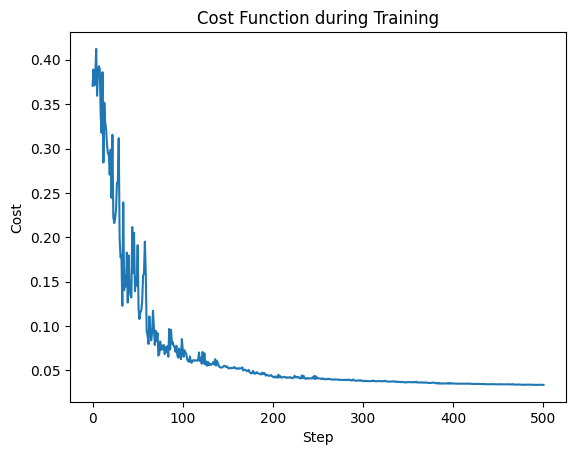

In [38]:
plt.plot(cost_values_digits)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [39]:
# Reset the qubits indicated by wir to zero
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [40]:
@qml.qnode(dev)
def autoencoder_digits(opt_weights, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(opt_weights, n_wires_latent, n_wires_trash)
    reset_to_zero([3, 4])
    qml.adjoint(ansatz_custom_digits)(opt_weights, n_wires_latent, n_wires_trash)
    #return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 5900x700 with 1 Axes>, <Axes: >)


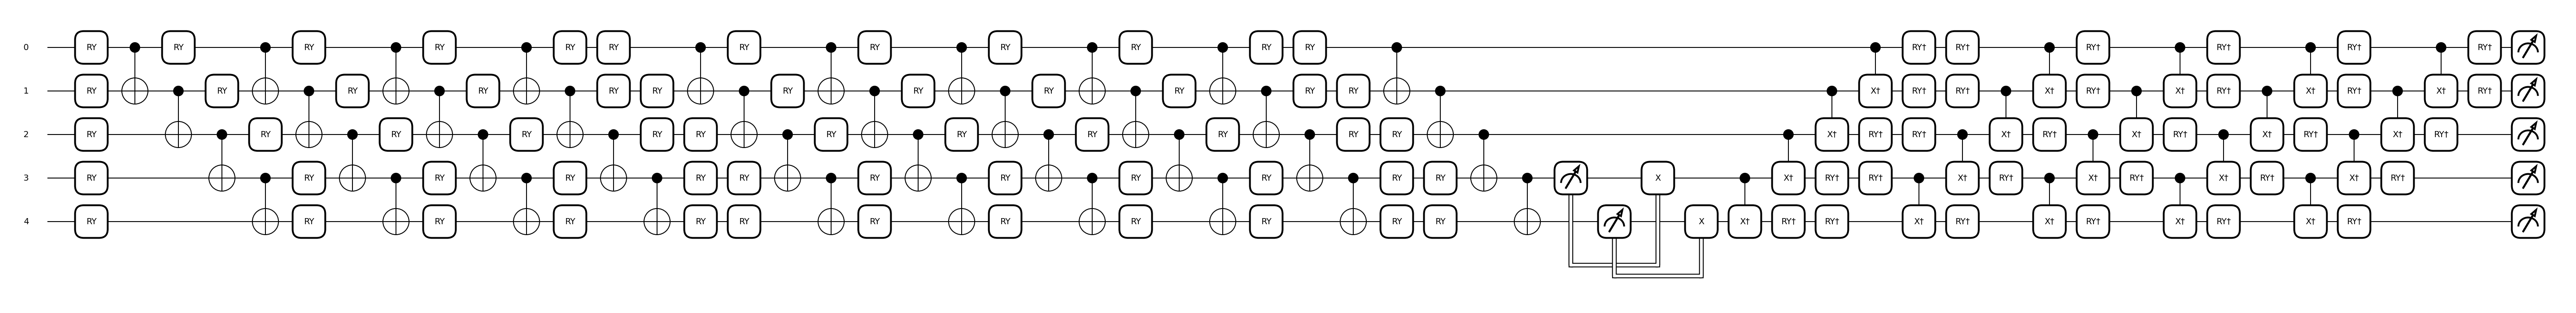

In [41]:
drawer_2 = qml.draw_mpl(autoencoder_digits)
print(drawer_2(opt_weights_digits, image_0))

In [42]:
@qml.qnode(dev)
def initial_image(image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    #return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 2100x600 with 1 Axes>, <Axes: >)


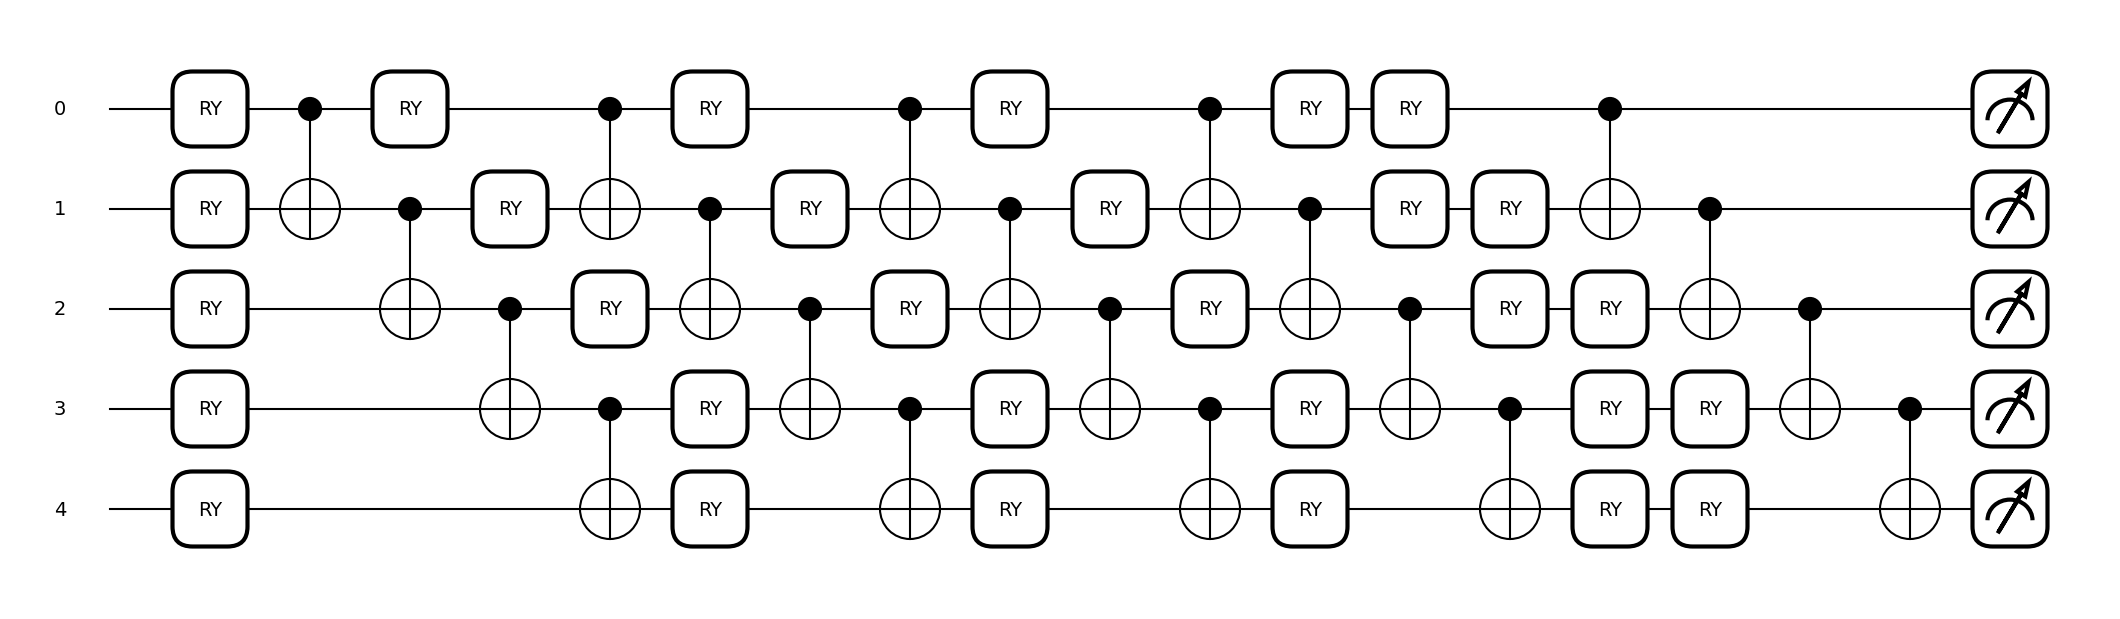

In [43]:
drawer_2 = qml.draw_mpl(initial_image)
print(drawer_2(image_0))

In [44]:
print(qml.math.fidelity(initial_image(image_0), autoencoder_digits(opt_weights_digits, image_0)))

0.9212457761580968


In [45]:
print(qml.math.fidelity(initial_image(image_1), autoencoder_digits(opt_weights_digits, image_1)))

0.8266450315410535


# To not use "reset_to_zero" #

In [46]:
dev_autoencoder_digits = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash+2)
@qml.qnode(dev_autoencoder_digits)
def autoencoder_digits_swap(opt_weights, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom(image, n_wires_latent, n_wires_trash) 
    ansatz_custom(opt_weights, n_wires_latent, n_wires_trash) 
    qml.SWAP(wires=[3, 6])
    qml.SWAP(wires=[4, 5])
    qml.adjoint(ansatz_custom)(opt_weights, n_wires_latent, n_wires_trash)
    return qml.density_matrix([0,1,2,3,4])

(<Figure size 5700x800 with 1 Axes>, <Axes: >)


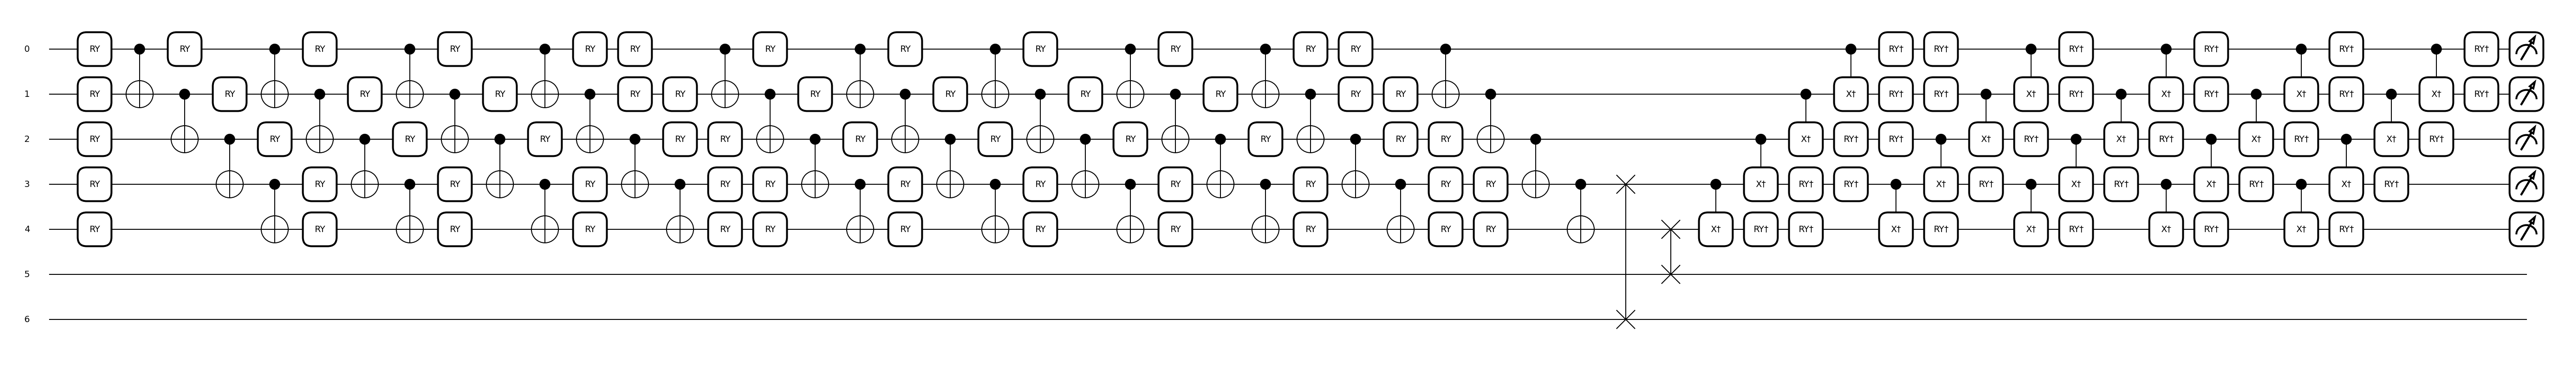

In [47]:
drawer_2 = qml.draw_mpl(autoencoder_digits_swap)
print(drawer_2(opt_weights_digits, image_0))

In [48]:
print(qml.math.fidelity(initial_image(image_0), autoencoder_digits_swap(opt_weights_digits, image_0)))

0.9212457760598071


In [49]:
print(qml.math.fidelity(initial_image(image_1), autoencoder_digits_swap(opt_weights_digits, image_1)))

0.8266450310623416
